# Emotional State Classifier on a multimodal physiological Dataset.

### Sina Dabiri
### sdabiri3@gatech.edu, sdabiri@emory.edu
### Version 1.0

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
import sys
import mne
import time
import pickle
import argparse

In [98]:
from mne.preprocessing import ICA, create_eog_epochs
from scipy.stats import skew, kurtosis
from scipy.signal import argrelextrema
import scipy.signal as signal
from scipy.fft import fft
import heartpy as hp
import pprint

In [4]:
pwd

'C:\\Users\\sinad\\OneDrive - Georgia Institute of Technology\\BMED 6517 ML Biosci\\Project\\emotional_state_classifier\\BMED_6517_emotional_state_classifier'

### 1: Preprocessing

In [8]:
# Setting the path for root directory for DEAP dataset, data folder, participants ratings, and EEG channel lists

root_folder = 'C:\\Users\\sinad\OneDrive - Georgia Institute of Technology\\BMED 6517 ML Biosci\\Project\\emotional_state_classifier\\DEAP\\DEAP'
data_folder = root_folder + '\data_preprocessed_python'
ratings_csv_path = root_folder + '\Metadata\metadata_csv\participant_ratings.csv'
DEAP_EEG_channels_xlsx_path = root_folder + '\Metadata\DEAP_EEG_channels.xlsx'

In [9]:
npy_folder = os.path.join(os.getcwd(), 'results', 'npy')
print(npy_folder)

for folder in [npy_folder]:
    if not os.path.exists(folder):
        os.makedirs(folder, exist_ok=True)

C:\Users\sinad\OneDrive - Georgia Institute of Technology\BMED 6517 ML Biosci\Project\emotional_state_classifier\BMED_6517_emotional_state_classifier\results\npy


In [10]:
N_trials = 40
N_EEG_electrodes = 32
N_BIPOLAR = 16
sfreq = 128

print(raw.describe())

In [33]:
ratings = pd.read_csv(ratings_csv_path)
is_subject =  (ratings['Participant_id'] == subject_id)
ratings_subj = ratings[is_subject]
trial_pick_indices = []
print('\nPreparing EEG trial reordering, from presentation order, to video (Experiment_id) order')
for i in range(N_trials):
    exp_id = i+1
    is_exp = (ratings['Experiment_id'] == exp_id)
    trial_id = ratings_subj[is_exp]['Trial'].values[0]
    trial_pick_indices.append(trial_id - 1)
    print('Picking source (raw) trial #{:02} to fill target (npy) trial #{:02} | Experiment_id: {:02}'.format(trial_id, exp_id, exp_id))


Preparing EEG trial reordering, from presentation order, to video (Experiment_id) order
Picking source (raw) trial #24 to fill target (npy) trial #01 | Experiment_id: 01
Picking source (raw) trial #12 to fill target (npy) trial #02 | Experiment_id: 02
Picking source (raw) trial #16 to fill target (npy) trial #03 | Experiment_id: 03
Picking source (raw) trial #22 to fill target (npy) trial #04 | Experiment_id: 04
Picking source (raw) trial #15 to fill target (npy) trial #05 | Experiment_id: 05
Picking source (raw) trial #09 to fill target (npy) trial #06 | Experiment_id: 06
Picking source (raw) trial #19 to fill target (npy) trial #07 | Experiment_id: 07
Picking source (raw) trial #34 to fill target (npy) trial #08 | Experiment_id: 08
Picking source (raw) trial #17 to fill target (npy) trial #09 | Experiment_id: 09
Picking source (raw) trial #21 to fill target (npy) trial #10 | Experiment_id: 10
Picking source (raw) trial #37 to fill target (npy) trial #11 | Experiment_id: 11
Picking s

C:\Users\sinad\AppData\Local\Temp\ipykernel_32736\3692028190.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  trial_id = ratings_subj[is_exp]['Trial'].values[0]


In [34]:
print(ratings_subj, ratings_subj.dtypes)

     Participant_id  Trial  Experiment_id  Start_time  Valence  Arousal  \
920              24      1             19     2942276     7.03     5.05   
921              24      2             17     3843296     4.08     5.99   
922              24      3             23     4888772     1.00     8.06   
923              24      4             20     5893417     4.03     6.08   
924              24      5             22     6840282     3.03     6.06   
925              24      6             27     7788618     6.08     5.03   
926              24      7             18     9172970     8.96     7.00   
927              24      8             30    10188472     1.00     8.03   
928              24      9              6    11243454     5.96     5.99   
929              24     10             26    12168300     4.05     6.99   
930              24     11             21    13218999     1.96     8.05   
931              24     12              2    14268406     6.04     6.09   
932              24     1

### 2. Feature extraction: 

In [12]:
def statistics_feature(data):
    mean = np.mean(data)
    std = np.std(data)
    Skew = skew(data)
    kurt = kurtosis(data)
    mean_fst_absdiff = np.mean(abs(np.diff(data)))
    mean_snd_absdiff = np.mean(abs(np.diff(np.diff(data))))
    mean_fst_diff = np.mean(np.diff(data))
    mean_snd_diff = np.mean(np.diff(np.diff(data)))
    mean_neg_diff = np.mean(np.diff(data)[np.where(np.diff(data)<0)])
    proportion_neg_diff = len(np.where(np.diff(data)<0)[0])/(len(np.diff(data)))
    number_local_min = len(argrelextrema(data,np.less)[0])
    number_local_max = len(argrelextrema(data,np.greater)[0])
    f1 = [mean,std,Skew,kurt]
    f2 = [mean_fst_absdiff,mean_snd_absdiff,mean_fst_diff,mean_snd_diff,mean_neg_diff,proportion_neg_diff]
    f3 = [number_local_min,number_local_max]
    f = f1+f2+f3
    names = ['mean','std','skew','kurtosis','me.1absdf','me.2absdf','me.1df','me.2df','me.negdf','ro.negdf','num.argmi','num.argma']
    GSR_features = dict(zip(names, f))
    return GSR_features

#### 2.1: Heart Rate and GSR:

In [13]:
def extract_HR_features(subject_id,trial_num):

    trial = trial_num

    feats_folder = os.path.join(os.getcwd(), 'results', 'features_new')

    plet_path = os.path.join(feats_folder, 's{:02}_plet.npy'.format(subject_id))
    if os.path.exists(plet_path):
        print('\nFeatures are already saved.\nSkipping data extraction for Subject {:02}'.format(subject_id))

    print('\nExtracting features for Subject {:02}'.format(subject_id))

    # Load data
    plet_file_path = os.path.join(npy_folder, 's{:02d}_plet.npy'.format(subject_id))
    print('Loading preprocessed Plethysmograph from .npy file {}\n'.format(plet_path))
    plet_data = np.load(plet_file_path)

    wd, m = hp.process(plet_data[trial,:], sample_rate = sfreq)

    # set large figure
    # plt.figure(figsize=(7,4))

    # call plotter
    hp.plotter(wd, m, figsize=(7,3))
    plt.show()
    
    return m


Extracting features for Subject 24
Loading preprocessed Plethysmograph from .npy file C:\Users\sinad\OneDrive - Georgia Institute of Technology\BMED 6517 ML Biosci\Project\emotional_state_classifier\BMED_6517_emotional_state_classifier\results\features_new\s24_plet.npy



C:\Users\sinad\anaconda3\envs\emotional_state_env\lib\site-packages\heartpy\visualizeutils.py:119: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


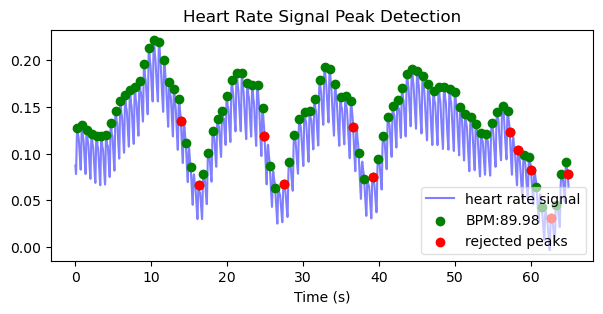

bpm: 89.981741
ibi: 666.801948
sdnn: 36.049951
sdsd: 18.895683
rmssd: 30.287775
pnn20: 0.522388
pnn50: 0.104478
hr_mad: 31.250000
sd1: 21.346583
sd2: 45.248247
s: 3034.450037
sd1/sd2: 0.471766
breathingrate: 0.133333


In [14]:
subject_id = 24
trial_num = 1

HR_feat = extract_HR_features(subject_id, trial_num)
for measure in HR_feat.keys():
    print('%s: %f' %(measure, HR_feat[measure]))

In [45]:
print(np.shape(HR_feat))

()


In [15]:
def extract_GSR_features(subject_id,trial_num):

    trial = trial_num

    feats_folder = os.path.join(os.getcwd(), 'results', 'features_new')

    GSR_path = os.path.join(feats_folder, 's{:02}_GSR.npy'.format(subject_id))
    if os.path.exists(GSR_path):
        print('\nFeatures are already saved.\nSkipping data extraction for Subject {:02}'.format(subject_id))

    print('\nExtracting features for Subject {:02}'.format(subject_id))

    # Load data
    GSR_file_path = os.path.join(npy_folder, 's{:02d}_GSR.npy'.format(subject_id))
    print('Loading preprocessed GSR from .npy file {}\n'.format(GSR_path))
    GSR_data = np.load(GSR_file_path)
    
    plt.figure(figsize=(7,3))
    plt.plot(GSR_data[trial,:])
    plt.show()
    
    features = statistics_feature(GSR_data)
    return features



Extracting features for Subject 24
Loading preprocessed GSR from .npy file C:\Users\sinad\OneDrive - Georgia Institute of Technology\BMED 6517 ML Biosci\Project\emotional_state_classifier\BMED_6517_emotional_state_classifier\results\features_new\s24_GSR.npy



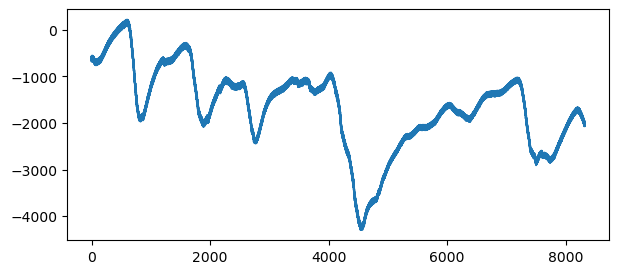

mean:  1070.3267617751926
std:  2006.310568280684
skew:  [1.88186571 1.89012933 1.85936534 ... 0.32140903 0.34282464 0.31856482]
kurtosis:  [ 3.45771985  3.5511357   3.36295244 ... -0.76459735 -0.71991634
 -0.74024196]
me.1absdf:  74.07927631752688
me.2absdf:  138.6191386898667
me.1df:  0.11703658818892068
me.2df:  0.0016441191909007844
me.negdf:  -74.06105902916048
ro.negdf:  4153.95
num.argmi:  107868
num.argma:  104653


In [16]:
gsr_feat = extract_GSR_features(subject_id, trial_num)
#pprint.pprint(gsr_feat)

for measure in gsr_feat.keys():
    print('%s: ' %(measure),gsr_feat[measure])

#### 2.2: EEG

In [17]:
from mne.preprocessing import ICA, create_eog_epochs

In [19]:
root_folder + '\data_preprocessed_python'
# root_folder = 'C:/Users/sinad/OneDrive - Georgia Institute of Technology/BMED 6517 ML Biosci/Project/emotional_state_classifier/DEAP/DEAP/data_original'
ratings_csv_path = 'C:\\Users\\sinad\OneDrive - Georgia Institute of Technology\\BMED 6517 ML Biosci\\Project\\emotional_state_classifier\\DEAP\\DEAP\\Metadata\metadata_csv\participant_ratings.csv' # os.path.join(os.getcwd(), 'metadata_csv', 'participant_ratings.csv')
DEAP_EEG_channels_xlsx_path = 'C:\\Users\\sinad\OneDrive - Georgia Institute of Technology\\BMED 6517 ML Biosci\\Project\\emotional_state_classifier\\DEAP\\DEAPMetadata\DEAP_EEG_channels.xlsx'

In [20]:
N_trials = 40
N_EEG_electrodes = 32
N_ICA = N_EEG_electrodes - 1

In [21]:
ICA_components_folder = os.path.join(os.getcwd(), 'results', 'ICA_components')
ICA_models_folder = os.path.join(os.getcwd(), 'results', 'ICA_models')
PSD_folder = os.path.join(os.getcwd(), 'results', 'PSD')
mneraw_as_pkl_folder = os.path.join(os.getcwd(), 'results', 'pkl')
npy_folder = os.path.join(os.getcwd(), 'results', 'npy')

In [22]:
for folder in [ICA_components_folder, ICA_models_folder, PSD_folder, mneraw_as_pkl_folder, npy_folder]:
	if not os.path.exists(folder):
		os.makedirs(folder, exist_ok=True)

def clean_bdf(subject_id):

	npy_path = os.path.join(npy_folder, 's{:02}.npy'.format(subject_id))
	if os.path.exists(npy_path):
		print('\nFile has already been preprocessed.\nSkipping EEG .bdf preprocessing for Subject {:02}'.format(subject_id))
		return 0

	print('\n----------------------------------------------------\n')
	print('Cleaning data for Subject {:02}'.format(subject_id))

	bdf_file_name = 's{:02d}.bdf'.format(subject_id)
	bdf_file_path = os.path.join(root_folder, bdf_file_name)
	
	print('Loading .bdf file {}'.format(bdf_file_path))
	raw = mne.io.read_raw_bdf(bdf_file_path, preload=True, verbose=False).load_data()
	ch_names = raw.ch_names
	eeg_channels = ch_names[:N_EEG_electrodes]
	non_eeg_channels = ch_names[N_EEG_electrodes:]
	stim_ch_name = ch_names[-1]
	stim_channels = [ stim_ch_name ]

	raw_copy = raw.copy()
	raw_stim = raw_copy.pick_channels(stim_channels)
	raw.pick_channels(eeg_channels)
	print('Setting montage with BioSemi32 electrode locations')
	biosemi_montage = mne.channels.make_standard_montage(kind='biosemi32', head_size=0.095)
	raw.set_montage(biosemi_montage)
	print('Applying notch filter (50Hz) and bandpass filter (4-45Hz)')
	raw.notch_filter(np.arange(50, 251, 50), n_jobs=1, fir_design='firwin')
	raw.filter(4, 45, fir_design='firwin')

	####################################
	# https://mne.tools/dev/generated/mne.set_eeg_reference.html
	# https://mne.tools/stable/auto_tutorials/preprocessing/plot_55_setting_eeg_reference.html
	# https://mne.tools/dev/auto_examples/preprocessing/plot_rereference_eeg.html
	# http://predictablynoisy.com/mne-python/auto_tutorials/plot_eeg_erp.html

	# **************
	# No reference. This assumes that the EEG has already been referenced properly.
	# This explicitly prevents MNE from adding a default EEG reference.
	# raw.set_eeg_reference([])
	# **************
	# Re-reference from an average reference to the mean of channels T7 and T8.
	# raw.set_eeg_reference(['T7', 'T8'])
	# **************
	# Average reference. This is normally added by default, but can also be added explicitly.
	print('Re-referencing all electrodes to the common average reference')
	raw.set_eeg_reference()
	#####################################################
	print('Getting events from the status channel')
	events = mne.find_events(raw_stim, stim_channel=stim_ch_name, verbose=True)
	if subject_id<=23:
		# Subject 1-22 and Subjects 23-28 have 48 channels.
		# Subjects 29-32 have 49 channels.
		# For Subjects 1-22 and Subject 23, the stimuli channel has the name 'Status'
		# For Subjects 24-28, the stimuli channel has the name ''
		# For Subjects 29-32, the stimuli channels have the names '-0' and '-1'
		pass
	else:
		# The values of the stimuli channel have to be changed for Subjects 24-32
		# Trigger channel has a non-zero initial value of 1703680 (consider using initial_event=True to detect this event)
		events[:,2] -= 1703680 # subtracting initial value
		events[:,2] = events[:,2] % 65536 # getting modulo with 65536
	
	print('')
	event_IDs = np.unique(events[:,2])
	for event_id in event_IDs:
		col = events[:,2]
		print('Event ID {} : {:05}'.format(event_id, np.sum( 1.0*(col==event_id) ) ) )
	inds_new_trial = np.where(events[:,2] == 4)[0]
	events_new_trial = events[inds_new_trial,:]
	baseline = (0, 0)
	print('Epoching the data, into [-5sec, +60sec] epochs')
	epochs = mne.Epochs(raw, events_new_trial, event_id=4, tmin=-5.0, tmax=60.0, picks=eeg_channels, baseline=baseline, preload=True)

	print('Fitting ICA to the epoched data, using {} ICA components'.format(N_ICA))
	ica = ICA(n_components=N_ICA, method='fastica', random_state=23)
	ica.fit(epochs)
	ICA_model_file = os.path.join(ICA_models_folder, 's{:02}_ICA_model.pkl'.format(subject_id))
	with open(ICA_model_file, 'wb') as pkl_file:
		pickle.dump(ica, pkl_file)
	# ica.plot_sources(epochs)
	print('Plotting ICA components')
	fig = ica.plot_components()
	cnt = 1
	for fig_x in fig:
		print(fig_x)
		fig_ICA_path = os.path.join(ICA_components_folder, 's{:02}_ICA_components_{}.png'.format(subject_id, cnt))
		fig_x.savefig(fig_ICA_path)
		cnt += 1
	# Inspect frontal channels to check artifact removal 
	# ica.plot_overlay(raw, picks=['Fp1'])
	# ica.plot_overlay(raw, picks=['Fp2'])
	# ica.plot_overlay(raw, picks=['AF3'])
	# ica.plot_overlay(raw, picks=['AF4'])
	N_excluded_channels = len(ica.exclude)
	print('Excluding {:02} ICA component(s): {}'.format(N_excluded_channels, ica.exclude))
	epochs_clean = ica.apply(epochs.copy())

	#############################

	print('Plotting PSD of epoched data')
	fig = epochs_clean.plot_psd(fmin=4, fmax=45, area_mode='range', average=False, picks=eeg_channels, spatial_colors=True)
	fig_PSD_path = os.path.join(PSD_folder, 's{:02}_PSD.png'.format(subject_id))
	fig.savefig(fig_PSD_path)

	print('Saving ICA epoched data as .pkl file')
	mneraw_pkl_path = os.path.join(mneraw_as_pkl_folder, 's{:02}.pkl'.format(subject_id))
	with open(mneraw_pkl_path, 'wb') as pkl_file:
		pickle.dump(epochs_clean, pkl_file)

	epochs_clean_copy = epochs_clean.copy()
	print('Downsampling epoched data to 128Hz')
	epochs_clean_downsampled = epochs_clean_copy.resample(sfreq=128.0)

	print('Plotting PSD of epoched downsampled data')
	fig = epochs_clean_downsampled.plot_psd(fmin=4, fmax=45, area_mode='range', average=False, picks=eeg_channels, spatial_colors=True)
	fig_PSD_path = os.path.join(PSD_folder, 's{:02}_PSD_downsampled.png'.format(subject_id))
	fig.savefig(fig_PSD_path)

	data = epochs_clean.get_data()
	data_downsampled = epochs_clean_downsampled.get_data()
	print('Original epoched data shape: {}'.format(data.shape))
	print('Downsampled epoched data shape: {}'.format(data_downsampled.shape))
	
	###########################################
	
	EEG_channels_table = pd.read_excel(DEAP_EEG_channels_xlsx_path)
	EEG_channels_geneva = EEG_channels_table['Channel_name_Geneva'].values
	channel_pick_indices = []
	print('\nPreparing EEG channel reordering to comply with the Geneva order')
	for (geneva_ch_index, geneva_ch_name) in zip(range(N_EEG_electrodes), EEG_channels_geneva):
		bdf_ch_index = eeg_channels.index(geneva_ch_name)
		channel_pick_indices.append(bdf_ch_index)
		print('Picking source (raw) channel #{:02} to fill target (npy) channel #{:02} | Electrode position: {}'.format(bdf_ch_index + 1, geneva_ch_index + 1, geneva_ch_name))

	ratings = pd.read_csv(ratings_csv_path)
	is_subject =  (ratings['Participant_id'] == subject_id)
	ratings_subj = ratings[is_subject]
	trial_pick_indices = []
	print('\nPreparing EEG trial reordering, from presentation order, to video (Experiment_id) order')
	for i in range(N_trials):
		exp_id = i+1
		is_exp = (ratings['Experiment_id'] == exp_id)
		trial_id = ratings_subj[is_exp]['Trial'].values[0]
		trial_pick_indices.append(trial_id - 1)
		print('Picking source (raw) trial #{:02} to fill target (npy) trial #{:02} | Experiment_id: {:02}'.format(trial_id, exp_id, exp_id))
	
	# Store clean and reordered data to numpy array
	epoch_duration = data_downsampled.shape[-1]
	data_npy = np.zeros((N_trials, N_EEG_electrodes, epoch_duration))
	print('\nStoring the final EEG data in a numpy array of shape {}'.format(data_npy.shape))
	for trial_source, trial_target in zip(trial_pick_indices, range(N_trials)):
		data_trial = data_downsampled[trial_source]
		data_trial_reordered_channels = data_trial[channel_pick_indices,:]
		data_npy[trial_target,:,:] = data_trial_reordered_channels.copy()
	print('Saving the final EEG data in a .npy file')
	np.save(npy_path, data_npy)
	
	print('Raw EEG has been filtered, common average referenced, epoched, artifact-rejected, downsampled, trial-reordered and channel-reordered.')
	print('Finished.')

In [23]:
if __name__=='__main__':
	parser = argparse.ArgumentParser(description="Preprocessing the DEAP dataset's .bdf files")
	parser.add_argument('--subject_id', type=int, default=1, help="Subject ID")
	args = parser.parse_args()

	clean_bdf(args.subject_id)

usage: ipykernel_launcher.py [-h] [--subject_id SUBJECT_ID]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\sinad\AppData\Roaming\jupyter\runtime\kernel-33f2a3de-327b-4b31-a2f7-b8f06414be2f.json


SystemExit: 2

C:\Users\sinad\anaconda3\envs\emotional_state_env\lib\site-packages\IPython\core\interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


#### 2.3: EOG and EMG:

In [25]:
def extract_EOG_features(subject_id,trial_num):

    trial = trial_num

    feats_folder = os.path.join(os.getcwd(), 'results', 'features_new')

    EOG_path = os.path.join(feats_folder, 's{:02}_EOG.npy'.format(subject_id))
    if os.path.exists(EOG_path):
        print('\nFeatures are already saved.\nSkipping data extraction for Subject {:02}'.format(subject_id))

    print('\nExtracting features for Subject {:02}'.format(subject_id))

    # Load data
    EOG_file_path = os.path.join(npy_folder, 's{:02d}_EOG.npy'.format(subject_id))
    print('Loading preprocessed EOG from .npy file {}\n'.format(EOG_path))
    EOG_data = np.load(EOG_file_path)
    
    len_data = np.shape(EOG_data[trial,:,:])[1]
    print(len_data)
    legend = ['hEOG1','hEOG2','vEOG1', 'vEOG2']
    plt.figure(figsize=(7,3))
    plt.plot(np.arange(0,len_data), EOG_data[trial,0,:])
    plt.plot(np.arange(0,len_data), EOG_data[trial,1,:])
    plt.plot(np.arange(0,len_data), EOG_data[trial,2,:])
    plt.plot(np.arange(0,len_data), EOG_data[trial,3,:])
    plt.legend(labels=legend)
    plt.show()
    
    features = statistics_feature(EOG_data)
    return features


Extracting features for Subject 24
Loading preprocessed EOG from .npy file C:\Users\sinad\OneDrive - Georgia Institute of Technology\BMED 6517 ML Biosci\Project\emotional_state_classifier\BMED_6517_emotional_state_classifier\results\features_new\s24_EOG.npy

8320


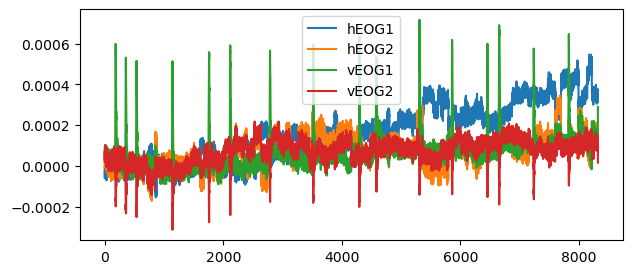

mean:  7.25995348931021e-05
std:  0.00015702547784584084
skew:  [[ 1.13550264  0.99332784  0.84610708 ...  0.40128525  0.22001331
   0.16570041]
 [ 1.70197058  0.60176249  1.87548038 ...  0.55436628  1.16898483
   0.80148154]
 [ 0.57518709  0.77856896  0.77426831 ...  0.29953847  0.19761345
   0.03739925]
 [-0.31427298 -0.28267195 -0.20754376 ... -0.44515172 -0.36865727
  -0.22606339]]
kurtosis:  [[ 4.47438757  3.28465741  2.58873531 ... -0.1673244  -0.83989082
  -0.31102711]
 [12.47562704 10.42081571 11.61601642 ...  4.50768902  5.4810007
   4.70620415]
 [ 0.79611653  1.09192387  1.42341279 ...  0.90176926  1.02202222
   0.71352449]
 [ 0.33230728  0.28720898  0.40914113 ...  0.98369483  1.76732372
   1.04301259]]
me.1absdf:  2.642962281956579e-05
me.2absdf:  4.793585791731982e-05
me.1df:  2.199707354746594e-08
me.2df:  -9.941360555623184e-10
me.negdf:  -2.633888155012256e-05
ro.negdf:  16681.425
num.argmi:  416272
num.argma:  422362


In [26]:
trial_num = 1
eog_feat = extract_EOG_features(subject_id, trial_num)
#pprint.pprint(gsr_feat)

for measure in eog_feat.keys():
    print('%s: ' %(measure),eog_feat[measure])

In [27]:
def extract_EMG_features(subject_id,trial_num):

    trial = trial_num

    feats_folder = os.path.join(os.getcwd(), 'results', 'features_new')

    EMG_path = os.path.join(feats_folder, 's{:02}_EMG.npy'.format(subject_id))
    if os.path.exists(EMG_path):
        print('\nFeatures are already saved.\nSkipping data extraction for Subject {:02}'.format(subject_id))

    print('\nExtracting features for Subject {:02}'.format(subject_id))

    # Load data
    EMG_file_path = os.path.join(npy_folder, 's{:02d}_EMG.npy'.format(subject_id))
    print('Loading preprocessed EMG from .npy file {}\n'.format(EMG_path))
    EMG_data = np.load(EMG_file_path)
    
    len_data = np.shape(EMG_data[trial,:,:])[1]
    print(len_data)
    legend = ['zEMG1','zEMG2','tEMG1', 'tEMG2']
    plt.figure(figsize=(7,3))
    plt.plot(np.arange(0,len_data), EMG_data[trial,0,:])
    plt.plot(np.arange(0,len_data), EMG_data[trial,1,:])
    plt.plot(np.arange(0,len_data), EMG_data[trial,2,:])
    plt.plot(np.arange(0,len_data), EMG_data[trial,3,:])
    plt.legend(labels=legend)
    plt.show()
    
    features = statistics_feature(EMG_data)
    return features


Extracting features for Subject 24
Loading preprocessed EMG from .npy file C:\Users\sinad\OneDrive - Georgia Institute of Technology\BMED 6517 ML Biosci\Project\emotional_state_classifier\BMED_6517_emotional_state_classifier\results\features_new\s24_EMG.npy

8320


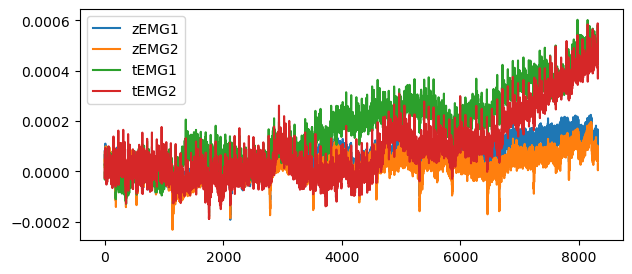

mean:  3.533245081232683e-05
std:  0.000522598005814456
skew:  [[-0.37928025 -0.30636735 -0.10903541 ... -0.94930538 -0.85221181
  -0.8192324 ]
 [ 0.02848042 -0.07484976 -0.13988532 ... -0.69536145 -0.79793655
  -0.55973643]
 [-3.71173766 -3.50300565 -3.74281871 ...  3.16541301  3.11673882
   3.19012602]
 [-1.02913354 -0.75283232 -0.90388981 ... -4.39220681 -4.44284158
  -4.41242009]]
kurtosis:  [[-3.94319802e-01 -5.59242405e-01  4.83079292e-02 ...  1.08876570e+00
   7.57043994e-01  9.09980434e-01]
 [-7.51568167e-01 -6.82297321e-01 -1.53652934e-01 ...  8.22965409e-03
   5.74487094e-01 -2.72130310e-01]
 [ 1.78760262e+01  1.65990940e+01  1.81022746e+01 ...  1.64838223e+01
   1.63610326e+01  1.66344412e+01]
 [ 1.25808563e+01  1.21332284e+01  1.24575207e+01 ...  2.34737656e+01
   2.38027583e+01  2.36183461e+01]]
me.1absdf:  2.7175036043891104e-05
me.2absdf:  4.861201402673252e-05
me.1df:  2.2691820446658245e-08
me.2df:  -1.5695402208306983e-09
me.negdf:  -2.726496501444202e-05
ro.negdf:  1

In [28]:
trial_num = 1
emg_feat = extract_EMG_features(subject_id, trial_num)
#pprint.pprint(gsr_feat)

for measure in emg_feat.keys():
    print('%s: ' %(measure),emg_feat[measure])

### 3. Feature Selection

#### 3.1: combine features

In [29]:
len_HR_feat = len(HR_feat)
print(HR_feat,'\n', len_HR_feat, '\n')

hr_gsr_df = pd.DataFrame.from_dict([HR_feat, gsr_feat], 'columns')
hr_gsr_df.head()


{'bpm': 89.98174071819841, 'ibi': 666.8019480519481, 'sdnn': 36.04995097584653, 'sdsd': 18.895682741562172, 'rmssd': 30.287774575110113, 'pnn20': 0.5223880597014925, 'pnn50': 0.1044776119402985, 'hr_mad': 31.25, 'sd1': 21.34658270380601, 'sd2': 45.248246966229864, 's': 3034.4500374995, 'sd1/sd2': 0.4717659607837981, 'breathingrate': 0.13333333333333333} 
 13 



,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,...,skew,kurtosis,me.1absdf,me.2absdf,me.1df,me.2df,me.negdf,ro.negdf,num.argmi,num.argma
0,89.981741,666.801948,36.049951,18.895683,30.287775,0.522388,0.104478,31.25,21.346583,45.248247,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[1.881865710678318, 1.8901293268048964, 1.8593...","[3.4577198515545398, 3.5511356967461314, 3.362...",74.079276,138.619139,0.117037,0.001644,-74.061059,4153.95,107868.0,104653.0


In [30]:
eog_emg_df = pd.DataFrame.from_dict([eog_feat, emg_feat])
eog_emg_df.head()

,mean,std,skew,kurtosis,me.1absdf,me.2absdf,me.1df,me.2df,me.negdf,ro.negdf,num.argmi,num.argma
0,0.000073,0.000157,"[[1.1355026414084566, 0.9933278361097694, 0.84...","[[4.474387566870537, 3.2846574064250795, 2.588...",0.000026,0.000048,2.199707e-08,-9.941361e-10,-0.000026,16681.425,416272,422362
1,0.000035,0.000523,"[[-0.37928025129468385, -0.3063673503113746, -...","[[-0.3943198020087526, -0.5592424046254347, 0....",0.000027,0.000049,2.269182e-08,-1.569540e-09,-0.000027,16569.275,409251,420089


In [31]:
x_train_feats = pd.concat([hr_gsr_df,eog_emg_df])
x_train_feats.head()

,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,...,skew,kurtosis,me.1absdf,me.2absdf,me.1df,me.2df,me.negdf,ro.negdf,num.argmi,num.argma
0,89.981741,666.801948,36.049951,18.895683,30.287775,0.522388,0.104478,31.25,21.346583,45.248247,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[1.881865710678318, 1.8901293268048964, 1.8593...","[3.4577198515545398, 3.5511356967461314, 3.362...",74.079276,138.619139,1.170366e-01,1.644119e-03,-74.061059,4153.950,107868.0,104653.0
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[[1.1355026414084566, 0.9933278361097694, 0.84...","[[4.474387566870537, 3.2846574064250795, 2.588...",0.000026,0.000048,2.199707e-08,-9.941361e-10,-0.000026,16681.425,416272.0,422362.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[[-0.37928025129468385, -0.3063673503113746, -...","[[-0.3943198020087526, -0.5592424046254347, 0....",0.000027,0.000049,2.269182e-08,-1.569540e-09,-0.000027,16569.275,409251.0,420089.0


In [35]:
print(ratings_subj.columns)
# print(ratings_subj.)
y_vad = ratings_subj.iloc[:,4:7] #["Valence", "Arousal", "Dominance"]
# y_vad
print(y_vad.head())
y_train = pd.DataFrame(y_vad)
y_train.head()

Index(['Participant_id', 'Trial', 'Experiment_id', 'Start_time', 'Valence',
       'Arousal', 'Dominance', 'Liking', 'Familiarity'],
      dtype='object')
     Valence  Arousal  Dominance
920     7.03     5.05       7.08
921     4.08     5.99       4.97
922     1.00     8.06       1.97
923     4.03     6.08       7.08
924     3.03     6.06       4.03


,Valence,Arousal,Dominance
920,7.03,5.05,7.08
921,4.08,5.99,4.97
922,1.00,8.06,1.97
923,4.03,6.08,7.08
924,3.03,6.06,4.03


In [36]:
# Combining: HR, GSR, EOG, and EMG. EEG is not working

feature_names = ['HR', 'GSR', 'EOG', 'EMG']
print(np.shape(x_train_feats), np.shape(y_train))
col=feature_names + ['y']
print(col, np.shape(col))

(4, 25) (40, 3)
['HR', 'GSR', 'EOG', 'EMG', 'y'] (5,)


In [37]:
# Seaborn visualization of features

df = pd.DataFrame(np.hstack([x_train_feats, y_train]), columns=col)
df.head()
df.describe()

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 40

In [ ]:
# sns.pairplot(df, hue='y', diag_kind=None);

In [38]:
ratings = pd.read_csv(ratings_csv_path)
ratings.head()

,Participant_id,Trial,Experiment_id,Start_time,Valence,Arousal,Dominance,Liking,Familiarity
0,1,1,5,1695918,6.96,3.92,7.19,6.05,4.0
1,1,2,18,2714905,7.23,7.15,6.94,8.01,4.0
2,1,3,4,3586768,4.94,6.01,6.12,8.06,4.0
3,1,4,24,4493800,7.04,7.09,8.01,8.22,4.0
4,1,5,20,5362005,8.26,7.91,7.19,8.13,1.0


In [46]:
subject_id = ratings['Participant_id'].unique()[0:22]
print(subject_id)
trial_id = ratings['Trial'].unique()
print(trial_id)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]


In [47]:
total_trials = len(subject_id)*len(trial_id)
print(total_trials)

880


In [81]:
eog_items = eog_feat.items()
# print(eog_items)
eog_list = list(eog_items)
# print(eog_list)
eog_array = np.array(eog_list)
eog_array_reshape = np.reshape(eog_array, (2,12))
print(np.shape(eog_array_reshape))
print(eog_array_reshape[1,:])

(2, 12)
['me.1df' 2.199707354746594e-08 'me.2df' -9.941360555623184e-10 'me.negdf'
 -2.633888155012256e-05 'ro.negdf' 16681.425 'num.argmi' 416272
 'num.argma' 422362]


C:\Users\sinad\AppData\Local\Temp\ipykernel_32736\178214129.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  eog_array = np.array(eog_list)


In [87]:
# eog_array_2 = []
eog_array_2_names = [eog_emg_df.columns]
print(eog_array_2_names)
eog_emg_df_np = eog_emg_df.to_numpy()
eog_array_2 = np.append(eog_array_2_names, eog_emg_df_np, axis=0)

print(np.shape(eog_array_2))
print(eog_array_2[0,:])
print(np.shape(eog_emg_df_np))
print(eog_emg_df_np)

[Index(['mean', 'std', 'skew', 'kurtosis', 'me.1absdf', 'me.2absdf', 'me.1df',
       'me.2df', 'me.negdf', 'ro.negdf', 'num.argmi', 'num.argma'],
      dtype='object')]
(3, 12)
['mean' 'std' 'skew' 'kurtosis' 'me.1absdf' 'me.2absdf' 'me.1df' 'me.2df'
 'me.negdf' 'ro.negdf' 'num.argmi' 'num.argma']
(2, 12)
[[7.25995348931021e-05 0.00015702547784584084
  array([[ 1.13550264,  0.99332784,  0.84610708, ...,  0.40128525,
           0.22001331,  0.16570041],
         [ 1.70197058,  0.60176249,  1.87548038, ...,  0.55436628,
           1.16898483,  0.80148154],
         [ 0.57518709,  0.77856896,  0.77426831, ...,  0.29953847,
           0.19761345,  0.03739925],
         [-0.31427298, -0.28267195, -0.20754376, ..., -0.44515172,
          -0.36865727, -0.22606339]])
  array([[ 4.47438757,  3.28465741,  2.58873531, ..., -0.1673244 ,
          -0.83989082, -0.31102711],
         [12.47562704, 10.42081571, 11.61601642, ...,  4.50768902,
           5.4810007 ,  4.70620415],
         [ 0.79611653

In [95]:
def extract_resp_feats(Resp,fs=128):
    # Respiration Features:
    # power in frequency bands 0.25 to 2.75 (windows of 0.25)
    # Mean peak value
    # mean magnitude of derivative
    # standard deviation
    # range

    # normalization ??? 

    # Respiration Data Preproc pipleline before feature 
    errors = []
    Resp -= Resp.mean()
    b_lp,a_lp = signal.butter(5,.1,btype='high',fs=128,analog=False)
    b_hp,a_hp = signal.butter(5,3,btype='low',fs=128,analog=False)
    Resp = signal.filtfilt(b_lp,a_lp,Resp)
    Resp = signal.filtfilt(b_hp,a_hp,Resp)
    
    # mean peak value
    peak_avg = np.zeros([Resp.shape[0],])
    for i in range(Resp.shape[0]):
        peaks = signal.find_peaks(Resp[i,:],height=300,width=75)
        if len(peaks[1]['peak_heights']) == 0:
            errors.append(i)
            peak_avg[i] = -1
        else:
            peak_avg[i] = peaks[1]['peak_heights'].mean()

    # Range
    range_feat = Resp.max(1) - Resp.min(1)

    # standard deviation
    std_feat = Resp.std(1)

    # mean magintude of derivative
    mean_der = np.abs(np.diff(Resp,axis=1)*fs).mean(1)

    # extracting power bands
    R_fft = fft(Resp)
    w = np.arange(0,Resp.shape[1]/2)*fs/Resp.shape[1]
    win_size = np.floor(0.25 * Resp.shape[1]/fs)//2
    fcs = np.linspace(0.25,2.5,10)
    ends = fcs+.25/2
    starts = fcs-.25/2
    means = []
    for i in range(10):
        start_idx = np.where((w>starts[i]))[0].min()
        end_idx = np.where((w<ends[i]))[0].max()
        means.append(np.mean(np.abs(R_fft[:,start_idx:end_idx]),axis=1))

    power_feats = np.vstack(means).T
    
    names = ['RMP1', 'RMP2','RMP3', 'RMP4','RMP5', 'RMP6','RMP7', 'RMP8','RMP9', 'RMP10', 'RRange','RMeanDer','Rstd','RMeanPeak' ]
    feats = np.hstack([power_feats,range_feat.reshape((40,1)),mean_der.reshape((40,1)),std_feat.reshape((40,1)),peak_avg.reshape((40,1))])
    return feats, names,errors

In [96]:
def extract_T_feats(T,fs=128):
    T_mean = T.mean(1)
    T_std = T.std(1)
    T_der = (np.diff(T,axis=1)*fs).mean(1)
    feats = np.vstack([T_mean,T_std,T_der]).T
    names = ['Tmean','Tstd','T_der']
    return feats,names

def extract_HR_feats(HR,fs=128):
    HR_feats = []
    errors = []
    for i in range(40):
        try:
            wd, m = hp.process(HR[i,:], sample_rate = fs)
            wd = hp.analysis.calc_rr(wd['peaklist'],sample_rate = 128,working_data = wd)
            HRV = np.sqrt(wd['RR_diff'].mean())
            feats = [HRV]
            names=['HRV']
            for key in m.keys():
                feats.append(m[key])
                names.append(key)
        except:
            feats = np.ones((14,))*-1
            errors.append(i)

        HR_feats.append(np.hstack(feats))
    HR_feats = np.vstack(HR_feats)
    return HR_feats, names, errors

def stat_feats(data,fs=128):
    mean = np.mean(data)
    std = np.std(data)
    Skew = skew(data)
    kurt = kurtosis(data)
    mean_fst_absdiff = np.mean(abs(np.diff(data)))
    mean_snd_absdiff = np.mean(abs(np.diff(np.diff(data))))
    mean_fst_diff = np.mean(np.diff(data))
    mean_snd_diff = np.mean(np.diff(np.diff(data)))
    mean_neg_diff = np.mean(np.diff(data)[np.where(np.diff(data)<0)])
    proportion_neg_diff = len(np.where(np.diff(data)<0)[0])/(len(np.diff(data)))
    number_local_min = len(argrelextrema(data,np.less)[0])
    number_local_max = len(argrelextrema(data,np.greater)[0])
    f1 = [mean,std,Skew,kurt]
    f2 = [mean_fst_absdiff,mean_snd_absdiff,mean_fst_diff,mean_snd_diff,mean_neg_diff,proportion_neg_diff]
    f3 = [number_local_min,number_local_max]
    f = f1+f2+f3
    names = ['Gmean','Gstd','Gskew','Gkurtosis','Gme.1absdf','Gme.2absdf','Gme.1df','Gme.2df','Gme.negdf','Gro.negdf','Gnum.argmi','Gnum.argma']
    return names,f

def extract_GSR_feats(gsr,fs=128):
    GSR_feats = []
    for i in range(40):
        names, feats = stat_feats(gsr[i,:])
        GSR_feats.append(feats)
    GSR_feats = np.vstack(GSR_feats)
    return GSR_feats, names


In [99]:
feat_names = ['hEOG','vEOG','zEMG','tEMG','GSR','Resp','Pleth','T']
feats = []
labels = []
all_errors = dict()
for i in range(1,23): # only the first 22 subjects now
    with open('C:\\Users\\sinad\OneDrive - Georgia Institute of Technology\\BMED 6517 ML Biosci\\Project\\emotional_state_classifier\\DEAP\\DEAP\\data_preprocessed_python\\s{:02d}.dat'.format(i),'rb') as file:
        #subj_labels = pickle.load(file,encoding='latin1')
        full = pickle.load(file,encoding='latin1')
        labels.append(full['labels'])
        data_non_eeg = full['data'][:,32:,:]
        data = dict()
        for j in range(len(feat_names)):
            data[feat_names[j]] = data_non_eeg[:,j,:]
    errors = []
    start = 3*128 # first three seconds are before trial starts. Will add this back in if needed for normalization
    R_feats,R_names,R_errors = extract_resp_feats(data['Resp'][:,start:])
    T_feats,T_names = extract_T_feats(data['T'][:,start:])
    HR_feats, HR_names,H_errors = extract_HR_feats(data['Pleth'][:,start:])
    errors = R_errors + H_errors
    GSR_feats, G_names = extract_GSR_feats(data['GSR'][:,start:])
    sub = np.ones((40,1))*i
    names = ['subject'] + R_names + T_names + HR_names + G_names
    feats.append(np.hstack([sub,R_feats,T_feats,HR_feats,GSR_feats]))
    if len(errors)>0:
        all_errors[str(i)] = errors

C:\Users\sinad\anaconda3\envs\emotional_state_env\lib\site-packages\scipy\interpolate\_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
C:\Users\sinad\anaconda3\envs\emotional_state_env\lib\site-packages\numpy\ma\core.py:5288: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
C:\Users\sinad\anaconda3\envs\emotional_state_env\lib\site-packages\numpy\core\fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\sinad\anaconda3\envs\emotional_state_env\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean

In [108]:
eog_data = [data.get(x)[:,start:] for x in ['hEOG','vEOG']]
print(np.shape(eog_data))

(2, 40, 7680)


In [89]:
npy_folder = os.path.join(os.getcwd(),root_folder, 'results', 'npy')

data_npy= np.empty((total_trials*2, 12))
tt = 0

for s in subject_id:
    
    for t in trial_id:
#       Read the preprocessed file and then save as .npy file
        
        np.save(npy_EOG_path, data_npy[:,0:4,:])
        np.save(npy_EMG_path, data_npy[:,4:8,:])
    
        eog_feat = extract_EOG_features(s, t)
        emg_feat = extract_EMG_features(t, t)
        eog_emg_df = pd.DataFrame.from_dict([eog_feat, emg_feat])
        data_npy[tt:tt+2,:]= eog_emg_df
        tt +=2
        
print(np.shape(data_npy))
eog_emg_names = [eog_emg_df.columns]
data_npy = np.append(eog_emg_names, eog_emg_df.to_numpy(), axis=0)
print(np.shape(data_npy))
np.save(npy_path, data_npy)


Extracting features for Subject 01
Loading preprocessed EOG from .npy file C:\Users\sinad\OneDrive - Georgia Institute of Technology\BMED 6517 ML Biosci\Project\emotional_state_classifier\BMED_6517_emotional_state_classifier\results\features_new\s01_EOG.npy



FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\sinad\\OneDrive - Georgia Institute of Technology\\BMED 6517 ML Biosci\\Project\\emotional_state_classifier\\BMED_6517_emotional_state_classifier\\results\\npy\\s01_EOG.npy'